In [1]:


import numpy as np 
import pandas as pd 




In [2]:
!pip install textstat

In [3]:
!pip install pyLDAvis

In [4]:
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from statistics import *
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import textstat

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium 
from folium import plugins 


def plot_readability(a,b,title,bins=0.1,colors=['#3A4750', '#F64E8B']):
    trace1 = ff.create_distplot([a,b], [" Real disaster tweets","Not real disaster tweets"], bin_size=bins, colors=colors, show_rug=False)
    trace1['layout'].update(title=title)
    py.iplot(trace1, filename='Distplot')
    table_data= [["Statistical Measures"," Not real disaster tweets","real disaster tweets"],
                ["Mean",mean(a),mean(b)],
                ["Standard Deviation",pstdev(a),pstdev(b)],
                ["Variance",pvariance(a),pvariance(b)],
                ["Median",median(a),median(b)],
                ["Maximum value",max(a),max(b)],
                ["Minimum value",min(a),min(b)]]
    trace2 = ff.create_table(table_data)
    py.iplot(trace2, filename='Table')

punctuations = string.punctuation
stopwords = list(STOP_WORDS)

parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

import re
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def removeurl(raw_text):
    clean_text = re.sub(r'^https?:\/\/.*[\r\n]*', '', raw_text, flags=re.MULTILINE)
    return clean_text

D:\WisenProgramData\Anaconda3\lib\site-packages\pkg_resources\__init__.py:1151: DeprecationWarning:

Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.

D:\WisenProgramData\Anaconda3\lib\site-packages\pkg_resources\__init__.py:1151: DeprecationWarning:

Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.



In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [6]:
train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [7]:
test.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [8]:
train['text'] = train['text'].apply(lambda x:cleanhtml(x))
test['text'] = test['text'].apply(lambda x:cleanhtml(x))


train['text'] = train['text'].apply(lambda x:removeurl(x))
test['text'] = test['text'].apply(lambda x:removeurl(x))


In [9]:
cnt_srs = train['target'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Jet',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

In [10]:
cnt_ = train['location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
trace1 = go.Bar(
                x = cnt_.index,
                y = cnt_.values,
                name = "Number of tweets in dataset according to location",
                marker = dict(color = 'rgba(200, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )

data = [trace1]
layout = go.Layout(barmode = "group",title = 'Number of tweets in dataset according to location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [11]:
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]
cnt_1 = train1_df['location'].value_counts()
cnt_1.reset_index()
cnt_1 = cnt_1[:20,]

cnt_0 = train0_df['location'].value_counts()
cnt_0.reset_index()
cnt_0 = cnt_0[:20,]

trace1 = go.Bar(
                x = cnt_1.index,
                y = cnt_1.values,
                name = "Number of tweets about real disaster location wise",
                marker = dict(color = 'rgba(255, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
trace0 = go.Bar(
                x = cnt_0.index,
                y = cnt_0.values,
                name = "Number of tweets other than real disaster location wise",
                marker = dict(color = 'rgba(79, 82, 97, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets in dataset according to location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [14]:
df = train['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="specify_your_app_name_here")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

USA
New York
United States
London
Canada
Nigeria
UK
Los Angeles, CA
India
Mumbai
Washington, DC
Kenya


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Kenya',), **{}).
Traceback (most recent call last):
  File "D:\WisenProgramData\Anaconda3\lib\urllib\request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "D:\WisenProgramData\Anaconda3\lib\http\client.py", line 1244, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "D:\WisenProgramData\Anaconda3\lib\http\client.py", line 1290, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "D:\WisenProgramData\Anaconda3\lib\http\client.py", line 1239, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "D:\WisenProgramData\Anaconda3\lib\http\client.py", line 1026, in _send_output
    self.send(msg)
  File "D:\WisenProgramData\Anaconda3\lib\http\client.py", line 966, in send
    self.connect()
  File "D:\WisenProgramData\Anaconda3\lib\http\client.py", line 1406, in connect
    super().conn

Worldwide
Chicago, IL
Australia
California
California, USA
Everywhere
New York, NY
San Francisco


In [15]:
map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

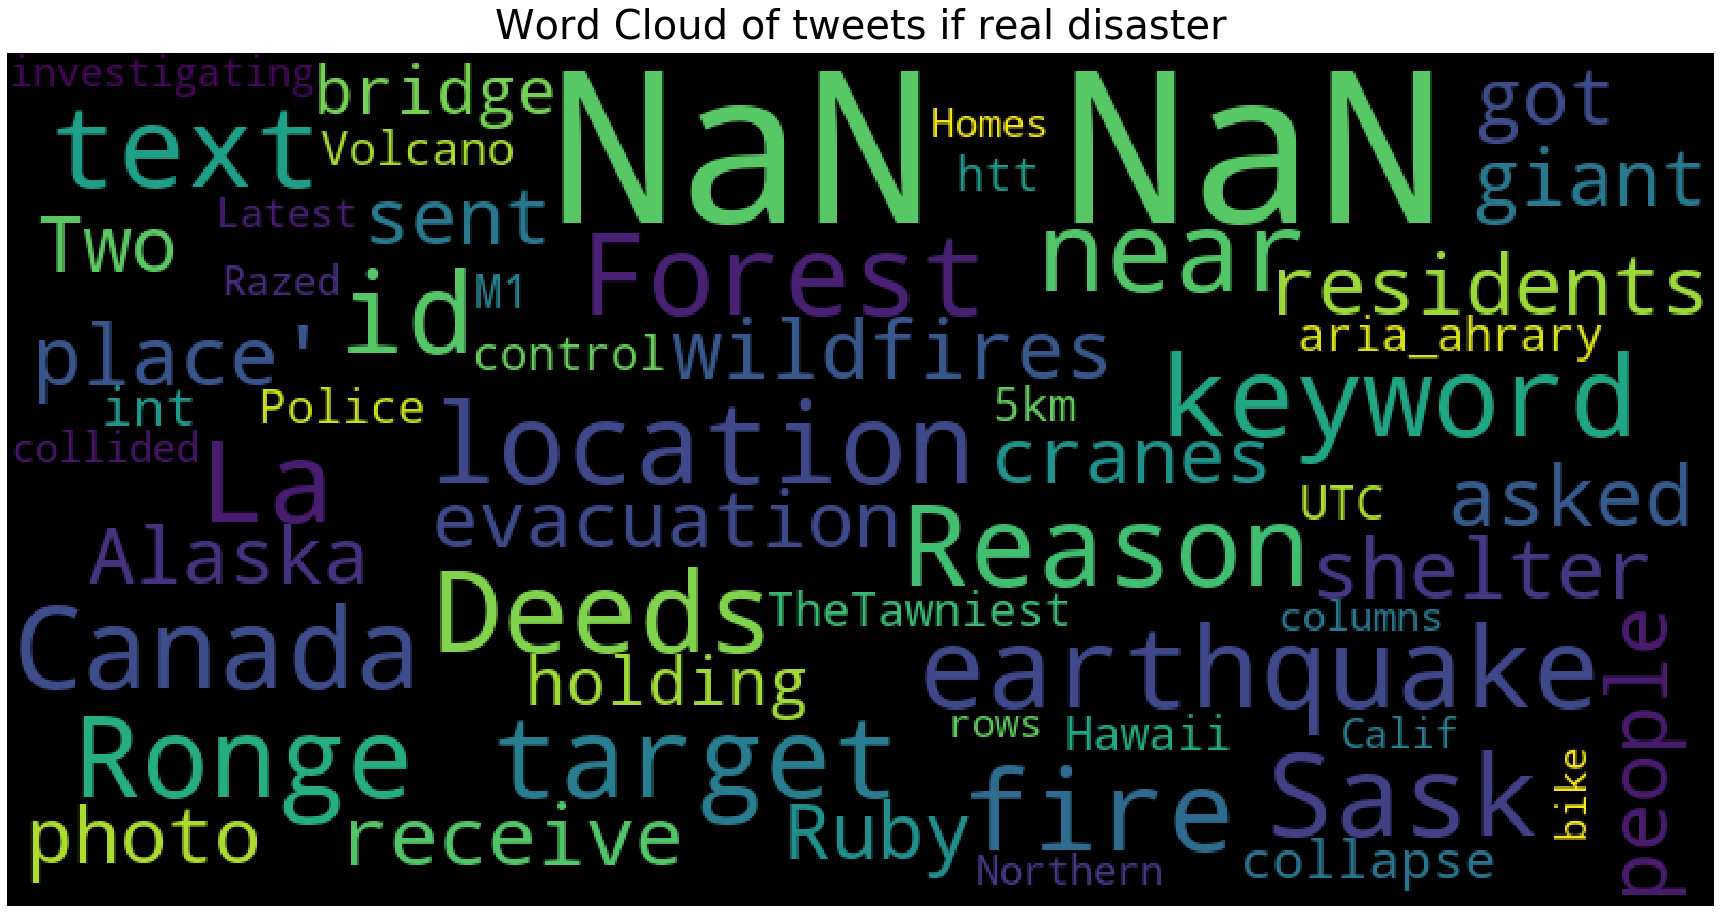

In [16]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train[train["target"]==1], title="Word Cloud of tweets if real disaster")

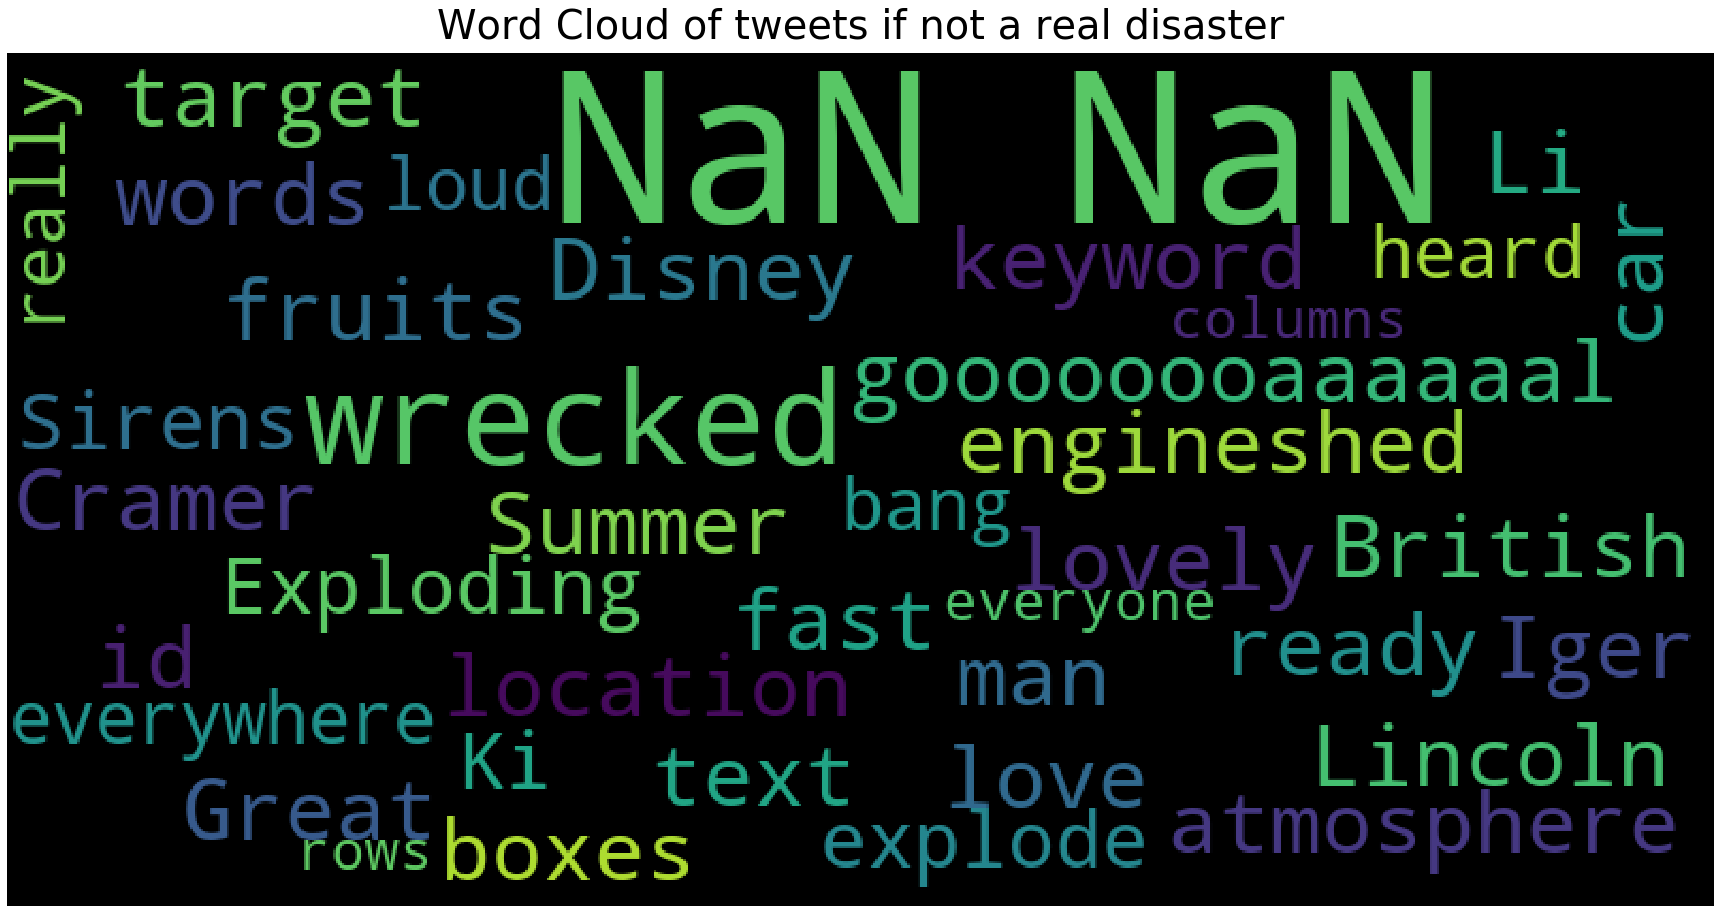

In [17]:
plot_wordcloud(train[train["target"]==0], title="Word Cloud of tweets if not a real disaster")

In [18]:
from collections import defaultdict
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'red')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words if tweet is not real disaster", 
                                          "Frequent words if tweet is real disaster"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')



D:\WisenProgramData\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

D:\WisenProgramData\Anaconda3\lib\site-packages\plotly\basedatatypes.py:1796: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


D:\WisenProgramData\Anaconda3\lib\site-packages\plotly\basedatatypes.py:1796: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




In [19]:
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent words if tweet is not real disaster", 
                                          "Frequent words if tweet is real disaster"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

D:\WisenProgramData\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

D:\WisenProgramData\Anaconda3\lib\site-packages\plotly\basedatatypes.py:1796: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


D:\WisenProgramData\Anaconda3\lib\site-packages\plotly\basedatatypes.py:1796: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




In [20]:
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent words if tweet is not real disaster", 
                                          "Frequent words if tweet is real disaster"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

D:\WisenProgramData\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

D:\WisenProgramData\Anaconda3\lib\site-packages\plotly\basedatatypes.py:1796: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


D:\WisenProgramData\Anaconda3\lib\site-packages\plotly\basedatatypes.py:1796: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




In [21]:
train["num_words"] = train["text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["text"].apply(lambda x: len(str(x).split()))


train["num_unique_words"] = train["text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["text"].apply(lambda x: len(set(str(x).split())))


train["num_chars"] = train["text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["text"].apply(lambda x: len(str(x)))


train["num_stopwords"] = train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test["num_stopwords"] = test["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))


train["num_punctuations"] =train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] =test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )


train["num_words_upper"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))


train["num_words_title"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))


train["mean_word_len"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

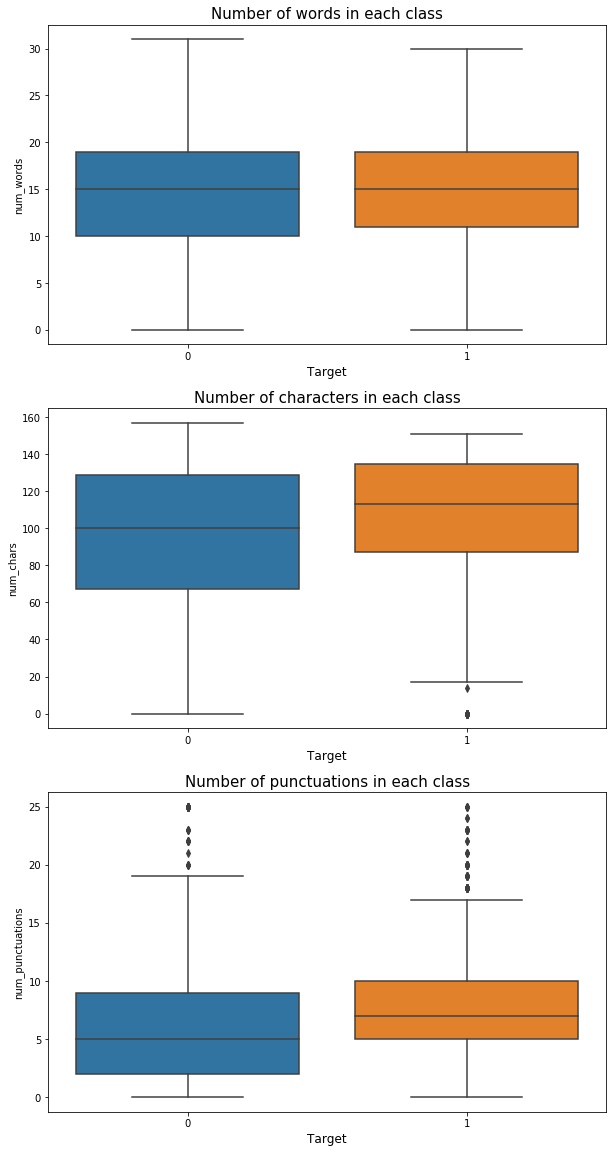

In [22]:
train['num_words'].loc[train['num_words']>60] = 100 #truncation for better visuals
train['num_punctuations'].loc[train['num_punctuations']>25] = 25 #truncation for better visuals
train['num_chars'].loc[train['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='target', y='num_words', data=train, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='target', y='num_chars', data=train, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='target', y='num_punctuations', data=train, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

In [23]:
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]

fig = go.Figure()
fig.add_trace(go.Histogram(x=train1_df['num_words'],name = 'Number of words in tweets about real disaster'))
fig.add_trace(go.Histogram(x=train0_df['num_words'],name = 'Number of words in tweets other than real disaster'))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [24]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train1_df['num_chars'],name = 'Number of chars in tweets about real disaster',marker = dict(color = 'rgba(200, 100, 0, 0.8)')))
fig.add_trace(go.Histogram(x=train0_df['num_chars'],name = 'Number of chars in tweets about real disaster',marker = dict(color = 'rgba(25, 133, 120, 0.8)')))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [25]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train1_df['num_punctuations'],name = 'Number of punctuations in tweets about real disaster',marker = dict(color = 'rgba(97, 175, 222, 0.8)')))
fig.add_trace(go.Histogram(x=train0_df['num_punctuations'],name = 'Number of punctuations in tweets other than real disaster',marker = dict(color = 'rgba(200, 10, 150, 0.8)')))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=1)
fig.show()

In [26]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train['num_words'],name = 'Number of words in training tweets',marker = dict(color = 'rgba(255, 0, 0, 0.8)')))
fig.add_trace(go.Histogram(x=test['num_words'],name = 'Number of words in testing tweets ',marker = dict(color = 'rgba(0, 187, 187, 0.8)')))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [27]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train['num_chars'],name = 'Number of chars in training tweets',marker = dict(color = 'rgba(25, 13, 8, 0.8)')))
fig.add_trace(go.Histogram(x=test['num_chars'],name = 'Number of chars in testing tweets ',marker = dict(color = 'rgba(8, 25, 187, 0.8)')))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [28]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train['num_punctuations'],name = 'Number of punctuations in training tweets',marker = dict(color = 'rgba(222, 111, 33, 0.8)')))
fig.add_trace(go.Histogram(x=test['num_punctuations'],name = 'Number of punctuations in testing tweets ',marker = dict(color = 'rgba(33, 111, 222, 0.8)')))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [29]:
tqdm.pandas()
fre_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.flesch_reading_ease))
fre_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.flesch_reading_ease))
plot_readability(fre_notreal,fre_real,"Flesch Reading Ease",20)

100%|████████████████████████████████████████████████████████████████████████████| 3271/3271 [00:00<00:00, 5850.90it/s]


In [30]:
fkg_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.flesch_kincaid_grade))
fkg_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.flesch_kincaid_grade))
plot_readability(fkg_notreal,fkg_real,"Flesch Kincaid Grade",4,['#C1D37F','#491F21'])

100%|███████████████████████████████████████████████████████████████████████████| 3271/3271 [00:00<00:00, 13323.58it/s]


In [31]:
fog_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.gunning_fog))
fog_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.gunning_fog))
plot_readability(fog_notreal,fog_real,"The Fog Scale (Gunning FOG Formula)",4,['#E2D58B','#CDE77F'])

100%|████████████████████████████████████████████████████████████████████████████| 3271/3271 [00:00<00:00, 9181.23it/s]


In [32]:
ari_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.automated_readability_index))
ari_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.automated_readability_index))
plot_readability(ari_notreal,ari_real,"Automated Readability Index",10,['#488286','#FF934F'])

100%|███████████████████████████████████████████████████████████████████████████| 3271/3271 [00:00<00:00, 38231.30it/s]


In [33]:
cli_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.coleman_liau_index))
cli_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.coleman_liau_index))
plot_readability(cli_notreal,cli_real,"The Coleman-Liau Index",10,['#8491A3','#2B2D42'])

100%|███████████████████████████████████████████████████████████████████████████| 3271/3271 [00:00<00:00, 25920.31it/s]


In [34]:
lwf_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.linsear_write_formula))
lwf_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.linsear_write_formula))
plot_readability(lwf_notreal,lwf_real,"Linsear Write Formula",2,['#8D99AE','#EF233C'])

100%|███████████████████████████████████████████████████████████████████████████| 3271/3271 [00:00<00:00, 13225.43it/s]


In [35]:
dcr_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.dale_chall_readability_score))
dcr_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.dale_chall_readability_score))
plot_readability(dcr_notreal,dcr_real,"Dale-Chall Readability Score",1,['#C65D17','#DDB967'])

100%|███████████████████████████████████████████████████████████████████████████| 3271/3271 [00:00<00:00, 13557.90it/s]


In [36]:
def consensus_all(text):
    return textstat.text_standard(text,float_output=True)

con_notreal = np.array(train["text"][train["target"] == 0].progress_apply(consensus_all))
con_real = np.array(train["text"][train["target"] == 1].progress_apply(consensus_all))
plot_readability(con_notreal,con_real,"Readability Consensus based upon all the above tests",2)

100%|████████████████████████████████████████████████████████████████████████████| 3271/3271 [00:00<00:00, 3772.98it/s]


In [37]:
notreal_text = train["text"][train["target"] == 0].progress_apply(spacy_tokenizer)
real_text = train["text"][train["target"] == 1].progress_apply(spacy_tokenizer)
#count vectorization
vectorizer_notreal = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
notreal_vectorized = vectorizer_notreal.fit_transform(notreal_text)
vectorizer_real = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
real_vectorized = vectorizer_real.fit_transform(real_text)

<>:4: DeprecationWarning:

invalid escape sequence \-

<>:6: DeprecationWarning:

invalid escape sequence \-

<>:4: DeprecationWarning:

invalid escape sequence \-

<>:6: DeprecationWarning:

invalid escape sequence \-

<>:4: DeprecationWarning:

invalid escape sequence \-

<>:6: DeprecationWarning:

invalid escape sequence \-

<ipython-input-37-58bf4d331be0>:4: DeprecationWarning:

invalid escape sequence \-

<ipython-input-37-58bf4d331be0>:6: DeprecationWarning:

invalid escape sequence \-

100%|████████████████████████████████████████████████████████████████████████████| 3271/3271 [00:01<00:00, 3060.59it/s]


In [38]:
# Latent Dirichlet Allocation Model
lda_notreal = LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online',verbose=True)
notreal_lda = lda_notreal.fit_transform(notreal_vectorized)
lda_real = LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online',verbose=True)
real_lda = lda_real.fit_transform(real_vectorized)

iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


In [39]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [40]:
print("Not real disaster tweets LDA Model:")
selected_topics(lda_notreal, vectorizer_notreal)

Not real disaster tweets LDA Model:
Topic 0:
[('going', 78.95573434643592), ('news', 67.95985301755476), ('life', 61.77433737669425), ('help', 48.3801438944724), ('trouble', 36.85466109406834), ('death', 35.536631092696), ('fuck', 33.40900713348848), ('wanna', 32.40427394816609), ('hope', 31.577034267257986), ('high', 26.527751822565044)]
Topic 1:
[('http', 255.7554104077859), ('got', 91.84831090299637), ('body', 86.95240432618807), ('reddit', 64.8557897617233), ('police', 37.213478373172585), ('quarantine', 33.07999374231871), ('song', 32.40202900203305), ('loud', 31.727989711003424), ('bang', 31.614844625141654), ('cross', 31.588028708512276)]
Topic 2:
[('http', 161.6211339134855), ('want', 66.35298921368212), ('content', 55.82689560593801), ('great', 49.29221172985399), ('fear', 43.35656997266347), ('school', 39.06975922262558), ('little', 32.9057773747485), ('tonight', 26.793361915038556), ('woman', 26.494627894171046), ('horrible', 24.087422579609115)]
Topic 3:
[('http', 275.48981

In [41]:
print("Real disaster tweets LDA Model:")
selected_topics(lda_real, vectorizer_real)

Real disaster tweets LDA Model:
Topic 0:
[('http', 154.28198561582428), ('old', 75.16198591370022), ('emergency', 65.74767105735202), ('https', 50.7618454446067), ('video', 36.17879350178331), ('airport', 33.848746120478495), ('sandstorm', 32.91292973546682), ('state', 32.163376790944724), ('death', 31.970273186673), ('minute', 30.582321634149704)]
Topic 1:
[('http', 243.08299173811108), ('families', 115.90346802890927), ('confirmed', 88.74105066066802), ('malaysia', 63.1431557853143), ('conclusively', 61.493033462975504), ('water', 53.259263231822686), ('wounded', 46.60073399680627), ('dead', 43.46571036087491), ('time', 42.709243341350415), ('rescuers', 38.52572125866245)]
Topic 2:
[('http', 153.57025698182227), ('evacuation', 34.8659310849344), ('day', 32.169588128458486), ('massacre', 30.48795916821378), ('failure', 28.137117848975823), ('bodies', 23.118800123776957), ('picking', 20.686464386213686), ('virgin', 20.628611642042888), ('galactic', 18.922208732713948), ('mph', 18.68703

In [42]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda_notreal, notreal_vectorized, vectorizer_notreal, mds='tsne')
dash

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
7      32.420952   8.115230       1        1  13.140720
4       0.648955  71.707100       2        1  13.094848
3      71.019684   9.971006       3        1  11.000583
1       3.785981  33.185135       4        1  10.339188
0     -42.666500  -9.222070       5        1   9.204821
9      -3.621689 -43.526516       6        1   9.103124
5      -3.632402  -4.171708       7        1   8.754828
6     -36.584400  35.804413       8        1   8.516221
8      44.391380  50.615383       9        1   8.515572
2      40.235809 -31.591665      10        1   8.330096, topic_info=     Category         Freq      Term        Total  loglift  logprob
601   Default  1712.000000      http  1712.000000  30.0000  30.0000
602   Default   227.000000     https   227.000000  29.0000  29.0000
710   Default   240.000000      like   240.000000  28.0000  28.0000
29    Default   195.000000       amp   195.000000  27.0000  27.0000
829   Default   159.000000       new   159.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
1308  Topic10    15.492527     water    17.652282   2.3548  -4.7572
814   Topic10    20.199089  mudslide    27.662796   2.1708  -4.4920
601   Topic10   155.940959      http  1712.306438   0.0892  -2.4481
270   Topic10    14.547799     crush    25.991948   1.9049  -4.8202
117   Topic10    12.439967    blight    17.093910   2.1675  -4.9767

[413 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
12        6  0.956030    added
27        3  0.973421  america
29        3  0.994512      amp
30        4  0.974237  ancient
44        4  0.968735  appears
...     ...       ...      ...
1365      6  0.990022     year
1366      3  0.983082    years
1367      7  0.947860      yes
1370      6  0.982284  youtube
1371      1  0.979230     zone

[517 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 4, 2, 1, 10, 6, 7, 9, 3])

In [43]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda_real, real_vectorized, vectorizer_real, mds='tsne')
dash

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  15.188789
3       0.648955  71.707100       2        1  11.829609
8      71.019684   9.971006       3        1  11.324715
5       3.785981  33.185135       4        1  11.071069
0     -42.666500  -9.222070       5        1   9.550587
1      -3.621689 -43.526516       6        1   9.115469
4      -3.632402  -4.171708       7        1   8.519487
9     -36.584400  35.804413       8        1   8.433373
7      44.391380  50.615383       9        1   8.177305
2      40.235809 -31.591665      10        1   6.789597, topic_info=     Category        Freq        Term        Total  loglift  logprob
148   Default  116.000000  california   116.000000  30.0000  30.0000
42    Default  114.000000         amp   114.000000  29.0000  29.0000
1200  Default   96.000000    wreckage    96.000000  28.0000  28.0000
364   Default   99.000000    families    99.000000  27.0000  27.0000
1023  Default  127.000000     suicide   127.000000  26.0000  26.0000
...       ...         ...         ...          ...      ...      ...
421   Topic10   19.272249    galactic    21.792337   2.5669  -4.2820
359   Topic10   28.657623     failure    33.446959   2.5352  -3.8852
515   Topic10  156.411137        http  2158.971010   0.0649  -2.1882
320   Topic10   11.666109        east    18.367976   2.2359  -4.7840
337   Topic10   11.848976   evacuated    28.051834   1.8280  -4.7684

[421 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         4  0.967143     -year
3         4  0.963319       abc
6         1  0.641715  accident
6         5  0.235296  accident
6         8  0.106953  accident
...     ...       ...       ...
1206      4  0.896525     years
1206     10  0.081502     years
1210      7  0.948928     youth
1211      5  0.936677   youtube
1215      4  0.906655      zone

[491 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 9, 6, 1, 2, 5, 10, 8, 3])

In [44]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [45]:
train_y = train["target"].values

def runModel(train_X, train_y, test_X, test_y, test_X2):
    model = linear_model.LogisticRegression(C=5., solver='sag')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)[:,1]
    pred_test_y2 = model.predict_proba(test_X2)[:,1]
    return pred_test_y, pred_test_y2, model

print("Building model.")
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0]])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runModel(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break

Building model.


In [46]:
from tqdm import tqdm
def threshold_search(y_true, y_proba):
#reference: https://www.kaggle.com/hung96ad/pytorch-starter
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.001 for i in range(1000)]):
        score = metrics.f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result
search_result = threshold_search(val_y, pred_val_y)
search_result

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1158.11it/s]


{'threshold': 0.392, 'f1': 0.7572964669738863}

In [47]:
print("F1 score at threshold {0} is {1}".format(0.381, metrics.f1_score(val_y, (pred_val_y>0.381).astype(int))))
print("Precision at threshold {0} is {1}".format(0.381, metrics.precision_score(val_y, (pred_val_y>0.381).astype(int))))
print("recall score at threshold {0} is {1}".format(0.381, metrics.recall_score(val_y, (pred_val_y>0.381).astype(int))))

F1 score at threshold 0.381 is 0.7535795026375284
Precision at threshold 0.381 is 0.7552870090634441
recall score at threshold 0.381 is 0.7518796992481203


In [51]:
#loading markovify module
import markovify

ModuleNotFoundError: No module named 'markovify'

In [ ]:
#preparing dataset
data_notreal = train["text"][train["target"] == 0]
data_real = train["text"][train["target"] == 1]

In [48]:
text_model_notreal = markovify.NewlineText(data_notreal, state_size = 2)
text_model_real = markovify.NewlineText(data_real, state_size = 2)

In [49]:
for i in range(10):
    print(text_model_notreal.make_sentence())

Canceling Deal for 2 people but only on account of petition against destruction of sanctioned food: Vladimir Putin's press... http://t.co/QbMcSJaVt0
@BCFCTicketLady @Mr_Aamir_Javaid Can see you will inundated with complaints that you once thought were permanent.
I liked a @YouTube video from @dannyonpc http://t.co/AD38KWoGlh Battlefield Hardline - 11 pm women shouldn't even log onshit be a blast of wind from my neighbour's ass.
Join the Providence Health &amp; Services http://t.co/8KJ1wDAiGj #Jobs
@kirkmin after listening to curfew overtime and stuck in a car wow it hasn't sunk in we got backty school in a sinkhole. Then I heard about that..not coming out until 2017 and 2019 ?????? Vampiro is bleeding ??
Nuu that FAM?? fwt I'm Leave You In a world inundated with gifts of banana malt loaf now ??
@hashtagteaclub place out. It was instant pandemonium. Utter mayhem ensued!
Russian customs destroyed a total emotional catastrophe.
Three days off from Chicago... http://t.co/AOg5chjmVs http://